In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

In [9]:
class Signal_Generator:
    def __init__(self, total_time=1000, psd_file=None, num_sources=100, mean_amp=10, sigma_amp=2):
        self.total_time = total_time
        self.psd_file = psd_file
        self.num_sources = num_sources
        self.mean_amp = mean_amp
        self.sigma_amp = sigma_amp
        self.max_psd_freq = None  # Initialize to None
        self.min_psd_freq = None  # Initialize to None
        self.A = None
        self.omega = None
        self.theta = None
        self.generated_signal = None

    def read_psd_data(self):
        if self.psd_file:
            psd_data = np.loadtxt(self.psd_file)
            psd_freqs = psd_data[:, 0]
            psd_amps = psd_data[:, 1]

            # Extract max and min PSD frequencies
            self.max_psd_freq = np.max(psd_freqs)
            self.min_psd_freq = np.min(psd_freqs)

            return psd_freqs, psd_amps
        else:
            print("PSD file not provided. Please set the 'psd_file' attribute.")
            return None, None

    def plot_psd(self):
        psd_freqs, psd_amps = self.read_psd_data()

        if psd_freqs is not None and psd_amps is not None:
            plt.figure(figsize=(10, 6))
            plt.plot(psd_freqs, psd_amps)
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.title('Power Spectral Density (Log-scale)')
            plt.grid(True)
            plt.show()

    def generate_signal(self, amp_uselog=False, add_noise=True, noise_type='psd', noise_amplitude=1.0):
        self.read_psd_data()
        time_interval = 0.05 / self.max_psd_freq

        # Generate amplitude
        if amp_uselog:
            mean_logamp = np.log(self.mean_amp)
            sigma_logamp = np.log(self.sigma_amp)
            lnA = np.random.normal(loc=mean_logamp, scale=sigma_logamp, size=self.num_sources)
            self.A = np.exp(lnA)
        else:
            self.A = np.random.normal(loc=self.mean_amp, scale=self.sigma_amp, size=self.num_sources)

        mean_freq = (self.min_psd_freq + self.max_psd_freq) / 2
        sigma_freq = (self.max_psd_freq - self.min_psd_freq) / 6

        self.omega = np.random.normal(loc=2 * np.pi * mean_freq, scale=2 * np.pi * sigma_freq, size=self.num_sources)
        self.theta = np.random.uniform(0, 2 * np.pi, size=self.num_sources)

        num_samples = int(self.total_time / time_interval)
        t = np.linspace(0, self.total_time, num_samples, endpoint=False)
        d_t = np.zeros(num_samples)

        for i in range(self.num_sources):
            d_t += self.A[i] * np.sin(self.omega[i] * t + self.theta[i])

        df = pd.DataFrame({'Time': t, 'Clean_Signal': d_t})

        if add_noise:
            if noise_type == 'white':
                noise = np.random.normal(scale=noise_amplitude, size=num_samples)
                combined_signal = d_t + noise
            elif noise_type == 'psd' and self.psd_file:
                psd_freqs, psd_amps = self.read_psd_data()
                sample_rate = 1.0 / (t[1] - t[0])
                freqs = np.fft.fftfreq(num_samples, 1 / sample_rate)
                noise_psd = np.interp(freqs, psd_freqs, psd_amps)
                combined_fft = np.fft.fft(d_t) + noise_psd
                combined_signal = np.fft.ifft(combined_fft).real
                noise = combined_signal - d_t
            else:
                print("Invalid noise_type or missing PSD file. Adding no noise.")
                noise = np.zeros(num_samples)

            df['Noise'] = noise
            df['Signal'] = combined_signal

        self.generated_signal = df

        return df

    def plot_signal(self, df, column='Signal'):
        if df is not None and column in df.columns:
            plt.figure(figsize=(10, 6))
            plt.plot(df['Time'], df[column])
            plt.xlabel('Time')
            plt.ylabel(column)
            plt.title(f'Plot of {column}')
            plt.grid(True)
            plt.show()
        else:
            print(f"Please provide a valid DataFrame and column ('{column}' not found in DataFrame).")

    def plot_individual_components(self, num_components=5):
        if self.generated_signal is not None:
            plt.figure(figsize=(10, 6))
            t = self.generated_signal['Time']
            for i in range(min(num_components, self.num_sources)):
                component_signal = self.A[i] * np.sin(self.omega[i] * t + self.theta[i])
                plt.plot(t, component_signal, label=f'Component {i + 1}')

            plt.xlabel('Time')
            plt.ylabel('Signal')
            plt.title(f'Individual Components (Up to {num_components})')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("Please generate signal first.")

    def plot_fft(self, df=None, column='Signal'):
        if df is not None and column in df.columns:
            signal = df[column].to_numpy()
            sample_rate = 1.0 / (df['Time'].iloc[1] - df['Time'].iloc[0])
            fft_signal = fft(signal)
            freqs = np.fft.fftfreq(len(signal), 1 / sample_rate)

            positive_freqs = freqs[:len(freqs) // 2]
            positive_fft_signal = np.abs(fft_signal[:len(freqs) // 2])

            plt.figure(figsize=(12, 6))
            plt.plot(positive_freqs, positive_fft_signal)
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.title(f'Positive Frequencies Fourier Transform Spectrum of {column}')
            plt.tight_layout()
            plt.grid(True)
            plt.show()
        else:
            print("Please provide a valid DataFrame and column ('{column}' not found in DataFrame).")

In [10]:
SG = Signal_Generator(total_time=0.01, num_sources=1000,psd_file='LIGOL_noise_psd.txt',mean_amp=10, sigma_amp=2)

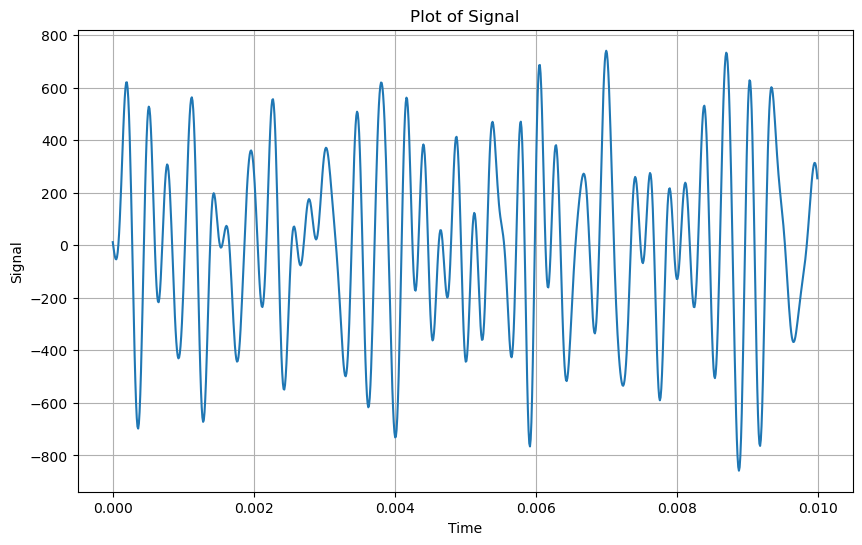

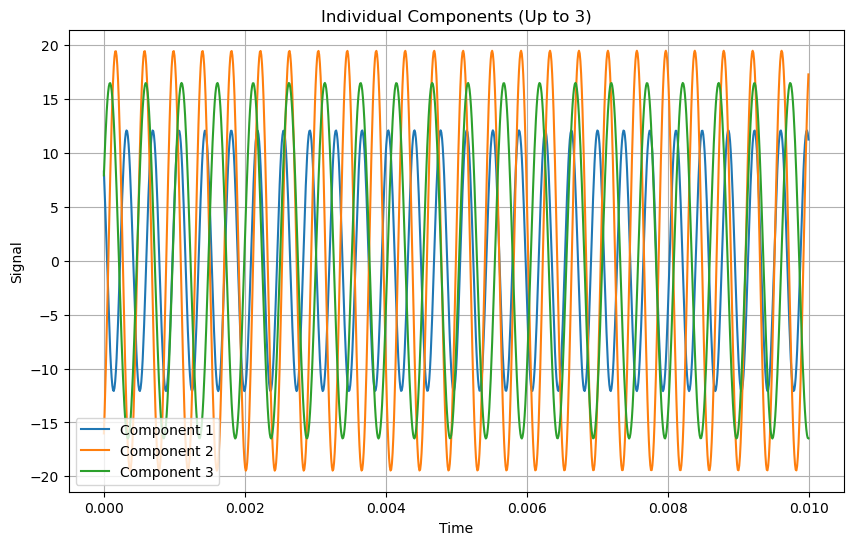

In [11]:
signal = SG.generate_signal(amp_uselog=True)
SG.plot_signal(signal)
SG.plot_individual_components(num_components=3)

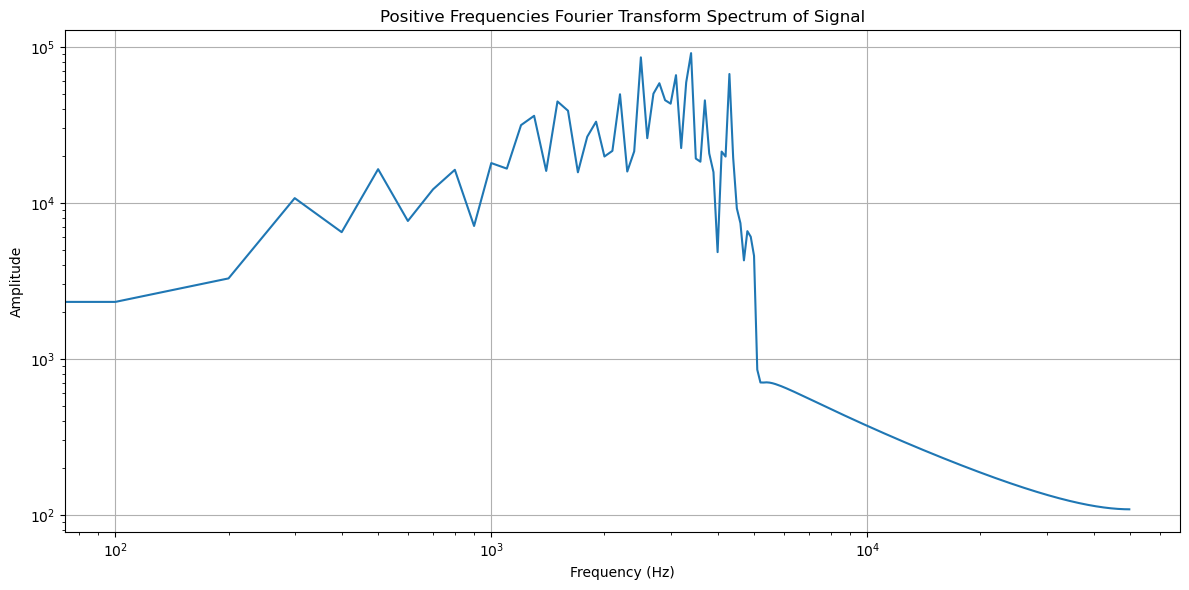

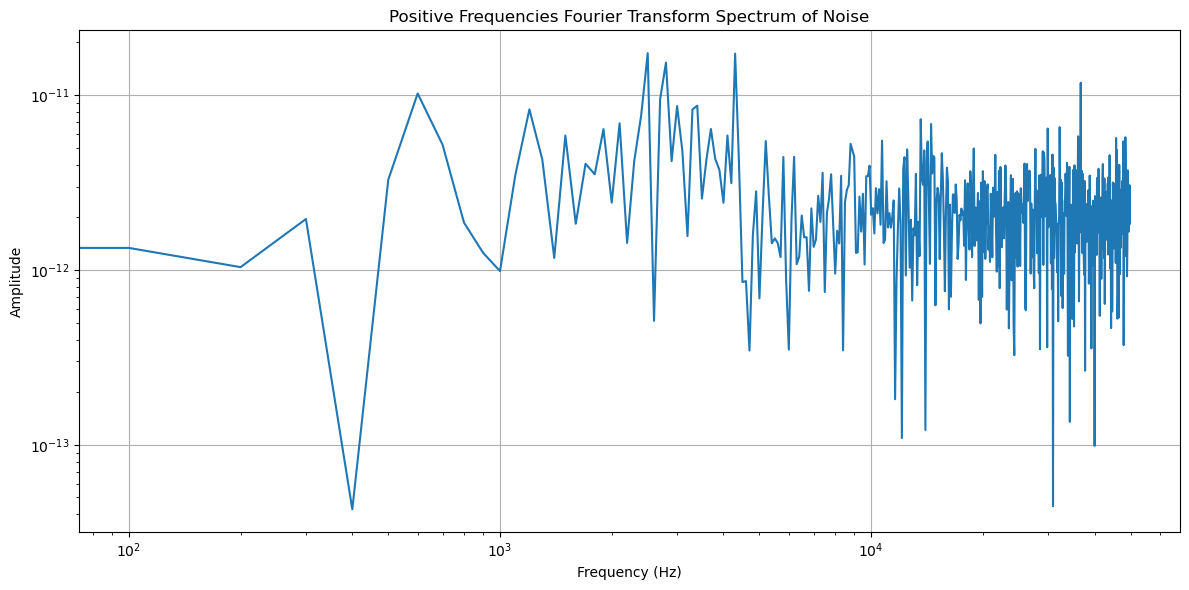

In [12]:
SG.plot_fft(signal)
SG.plot_fft(signal, column ='Noise')